In [1]:
pip install mesa==2.3.3

In [2]:
# We import the required classes to handle agents (Agent) and their environment (Model).
# Each model can contain multiple agents.
from mesa import Agent, Model

# Since we need only one agent per cell, we choose 'SingleGrid'.
from mesa.space import SingleGrid

# With 'RandomActivation', we make all agents activate 'at the same time'.
from mesa.time import RandomActivation

# We'll use 'batch_run' to execute multiple simulations
from mesa.batchrunner import batch_run

# We'll use seaborn to display more 'appealing' graphs of our model
import seaborn as sns

from functools import partial

# We'll use 'DataCollector' to obtain information from each step of the simulation.
from mesa.datacollection import DataCollector

# We'll use matplotlib to create an animation of each model step.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# We import the following packages for better handling of numerical values.
import numpy as np
import pandas as pd

# We define other packages that we'll use to measure the execution time of our algorithm.
import time
import datetime
import random

In [3]:
class VacuumCleaner(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.cleaned = 0
        self.visited = 0
        self.state = "Moving"

    def move(self, state, chosen_position):
      if state == "Moving":
        self.model.grid.remove_agent(self)
        if (self.model.grid.is_cell_empty(chosen_position) is False):
          self.model.decrease_dirty_cells()
        self.model.grid[chosen_position[0]][chosen_position[1]] = None
        self.model.grid.move_agent(self, chosen_position)
        self.state = "Cleaning"
      elif state == "Cleaning":
        self.state = "Moving"

    def step(self):
        vecinos = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        dirty_positions = [agent for agent in vecinos if isinstance(model.grid[agent[0]][agent[1]], Dirt)]
        empty_positions = [agent for agent in vecinos if self.model.grid[agent] is None]
        chosen_position = self.pos
        if dirty_positions:
            chosen_position = self.random.choice(dirty_positions)
            self.visited += 1
            self.cleaned += 1

        elif empty_positions:
            chosen_position = self.random.choice(empty_positions)
            self.visited += 1

        self.move(self.state, chosen_position)


In [4]:
class Dirt(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)

In [5]:
# Traverses the entire space and returns a matrix with agent types
def get_grid(model):
  grid = np.zeros((model.grid.width, model.grid.height))
  for content, (x, y) in model.grid.coord_iter():
    if content!= None:
      grid[x][y] = 2 if isinstance(content, VacuumCleaner) else 1
  return grid

In [6]:
class RoomModel(Model):
    def __init__(self, width, height, dirty_cells=0.90, vacuums=5):
        super().__init__()
        """
        Initializes the RoomModel with given dimensions,
        percentage of dirty cells, and number of vacuums.

        Args:
            width (int): Width of the room grid.
            height (int): Height of the room grid.
            dirty_cells (float): Percentage of cells initially dirty (default: 0.90).
            vacuums (int): Number of vacuum cleaner agents (default: 5).
        """
        self.grid = SingleGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.steps = 0
        self.vacuums = vacuums
        self.running = True  # The simulation runs until the room is clean.
        self.dirty_agents = 0
        self.datacollector = DataCollector(
            model_reporters={"Grid": get_grid, "Steps": lambda m: m.steps})

        # The model dirty the cells randomly
        num_dirty_cells = int(width * height * dirty_cells)
        dirty_cells_placed = 0
        self.dirty_agents = num_dirty_cells
        while dirty_cells_placed < num_dirty_cells:
            dirt_agent = Dirt(dirty_cells_placed + 1, self)
            self.grid.move_to_empty(dirt_agent)
            self.schedule.add(dirt_agent)
            dirty_cells_placed += 1

        # Place vacuum cleaners
        for i in range(self.vacuums):
            agent = VacuumCleaner(i, self)
            self.grid.move_to_empty(agent)
            self.schedule.add(agent)


    # Vacuum Cleaner Efficiency
    def vacuum_efficiency(self):
        avg_efficiency = 0
        for i in self.schedule.agents:
            if isinstance(i, VacuumCleaner):
                if i.visited > 0:
                    efficiency = i.cleaned / i.visited
                else:
                    efficiency = 0
                print(f"Vacuum Efficiency {i.unique_id}: {efficiency * 100:.2f}%")
                avg_efficiency += efficiency
        print()
        return avg_efficiency / self.vacuums


    def decrease_dirty_cells(self):
        self.dirty_agents -= 1

    def step(self):
        if self.dirty_agents == 0:
          print("Clean habitat. Finishing simulation.")
          return

        self.datacollector.collect(self)
        self.schedule.step()
        self.steps += 1


In [20]:
WIDTH = 20
HEIGHT = 20
DIRTY_CELLS = 0.90
VACUUMS = 5


model = RoomModel(WIDTH, HEIGHT, DIRTY_CELLS, VACUUMS)
while model.dirty_agents > 0:
  model.step()


print(f"Simulation {1}")
efficiency = model.vacuum_efficiency()
print(f"Number of steps: {model.steps}")


Simulation 1
Vacuum Efficiency 4: 13.91%
Vacuum Efficiency 0: 27.00%
Vacuum Efficiency 3: 24.06%
Vacuum Efficiency 1: 34.86%
Vacuum Efficiency 2: 17.18%

Number of steps: 611


In [49]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Grid    435 non-null    object
 1   Steps   435 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.9+ KB


C:\Users\alexs\AppData\Local\Temp\ipykernel_29324\1785511014.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grids.iloc[0][0], cmap=plt.cm.tab20)


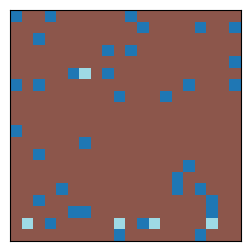

In [50]:
fig, axs = plt.subplots(figsize=(3,3))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0][0], cmap=plt.cm.tab20)

In [51]:
def animate(i):
  patch.set_data(all_grids.iloc[i,0])

anim = animation.FuncAnimation(fig, animate, frames=model.steps)
anim